<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Нам даны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

In [15]:
import pandas as pd
from sklearn.model_selection import  train_test_split, TimeSeriesSplit
from sklearn.metrics import          mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as          plt
from time import                     time

from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import         RandomForestRegressor
from sklearn.linear_model import     LinearRegression
from catboost import                 CatBoostRegressor
# from lightgbm import LGBMRegressor

import                               warnings
warnings.filterwarnings('ignore')
import os

In [16]:
#в окпужении почему-то нет этой модели
!pip install lightgbm

In [17]:
from lightgbm import LGBMRegressor

In [18]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

## Подготовка

In [19]:
# Сортируем даты и ресеплируем по часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [20]:
# Проверяем порядок сортировки
data.index.is_monotonic

True

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [22]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [23]:
data.isna().sum()

num_orders    0
dtype: int64

In [24]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Датасет чистый и содержит 2 столбца, дата (+время) и количество заказов. Столбец с датой преобразовали в индекс.
Данные предоставлены за период с 2018-03-01 по 2018-08-31

## Анализ

Посмотрим на значения на графике

<AxesSubplot:xlabel='datetime'>

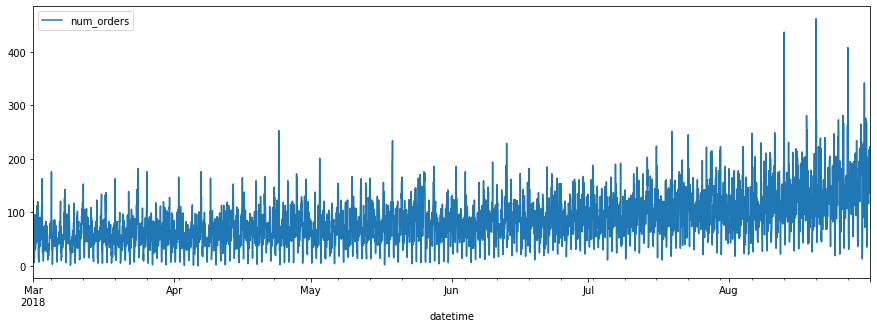

In [25]:
data.plot(figsize=(15, 5))

Количетво заказов растет со временем. Декомпозируем данные, выявим тренд, сезонность.

In [26]:
decomposed = seasonal_decompose(data) 

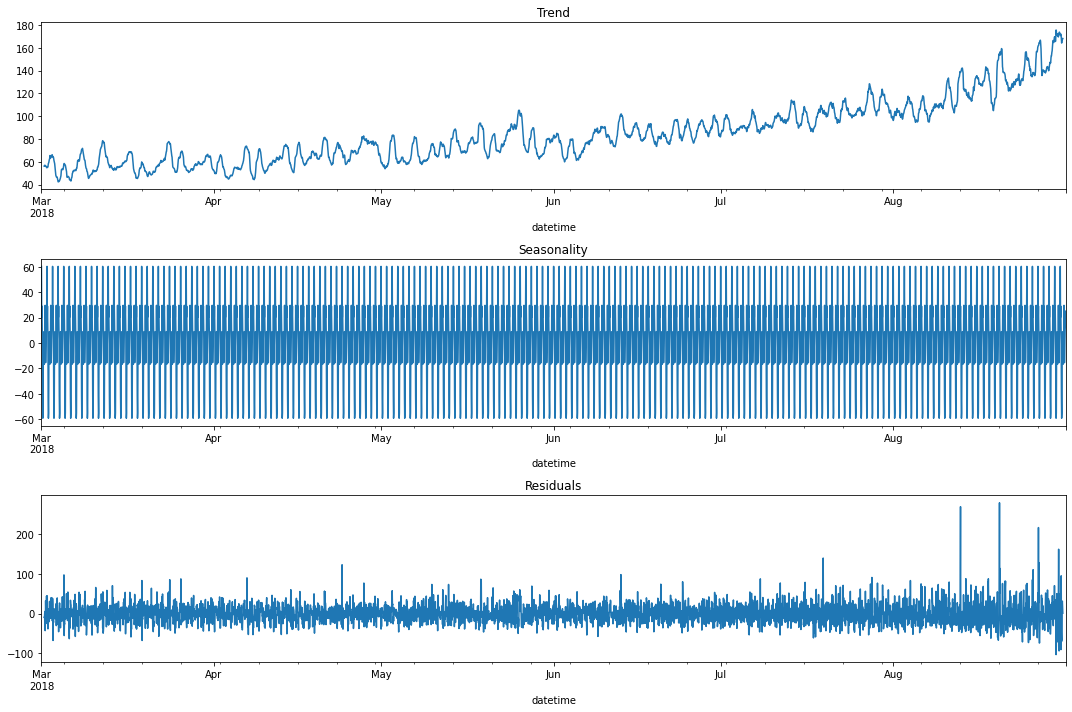

In [27]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Линия тренда движется вверх, что говорит пожтверждает увеличение количества заказов со временем.

<AxesSubplot:xlabel='datetime'>

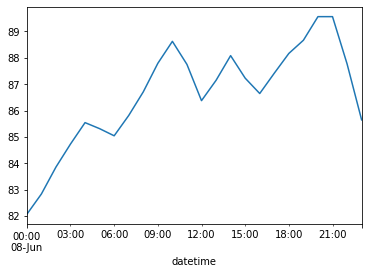

In [28]:
decomposed.trend['2018-06-08' : '2018-06-08'].plot()

К вечеру пятницы количество заказов возрастает

<AxesSubplot:xlabel='datetime'>

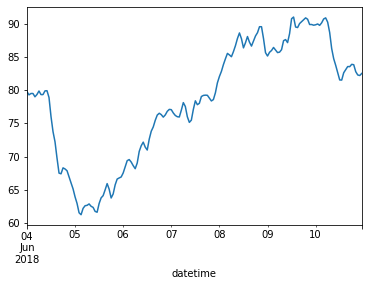

In [29]:
decomposed.trend['2018-06-04' : '2018-06-10'].plot()

На недельном графике виден спад заказов во вторник и увеличение количества к пятнице и выходным

<AxesSubplot:xlabel='datetime'>

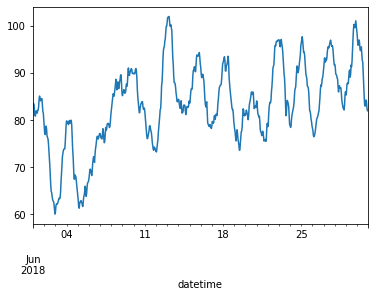

In [30]:
decomposed.trend['2018-06-01' : '2018-06-30'].plot()

<AxesSubplot:xlabel='datetime'>

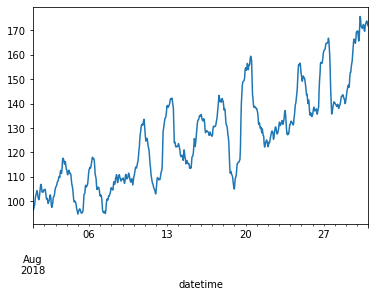

In [31]:
decomposed.trend['2018-08-01' : '2018-08-30'].plot()

Июнь и август отличаются, с начала лета количество заказов возрасло вдвое. 

<AxesSubplot:xlabel='datetime'>

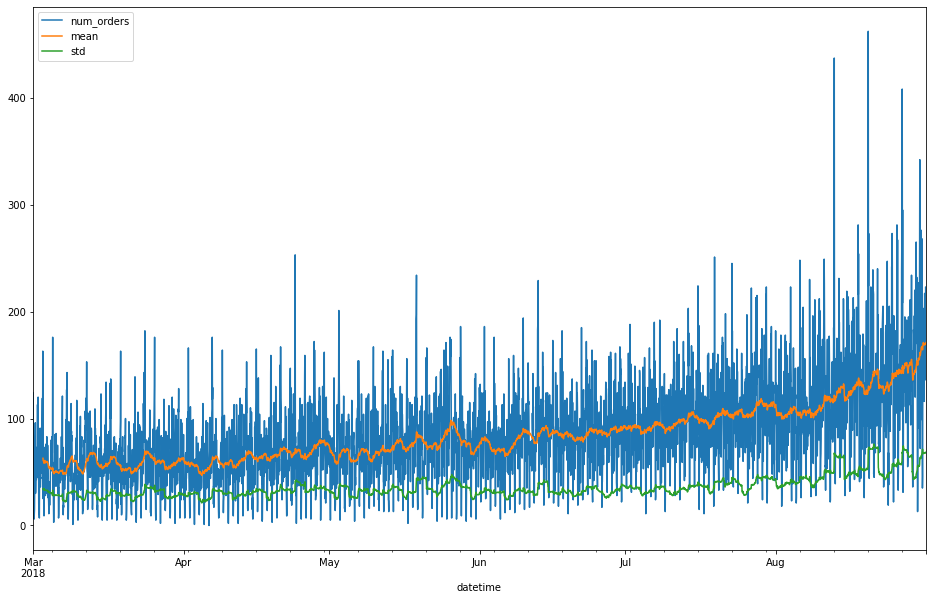

In [32]:
data1 = data.resample('1H').sum()
data1['mean'] = data['num_orders'].rolling(50).mean()
data1['std'] = data['num_orders'].rolling(50).std()
data1.plot(figsize=(16, 10)) 

Среднее значение и стандартное отклонение растут со временем.


## Обучение

Добавим признаки в датасет

In [33]:
def make_features(data, max_lag, rolling_mean_size):
#     data['year'] = data.index.year
#     data['month'] = data.index.month
#     data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [34]:
make_features(data, 1, 24)

In [35]:
# Разбиваем датасет на тестовую и тренировочную выборку
train, test = train_test_split(data, shuffle=False, train_size=0.9)
train = train.dropna()
test = test.dropna()

In [36]:
# Определим признаки и целевые значения
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [37]:
# Убедимся в правильности деления
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(3952, 4) (3952,)
(440, 4) (440,)


**Подбор гиперпараметров для RandomForestRegressor**

In [38]:
RFR_model = RandomForestRegressor(random_state = 2007)
RFR_param_search = { 
                    'n_estimators': [20, 50, 100],
                    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
RFR_gsearch = GridSearchCV(n_jobs = -1, estimator=RFR_model, cv=tscv, param_grid=RFR_param_search, scoring = 'neg_root_mean_squared_error')

RFR_gsearch.fit(features_train, target_train)

RFR_gsearch.best_params_

{'max_depth': 14, 'n_estimators': 100}

In [39]:
if RFR_gsearch.best_score_ < 0:
    RFR_gsearch.best_score_ = RFR_gsearch.best_score_* (-1)
RFR_gsearch.best_score_

25.48075881798519

**Подбор гиперпараметров для CatBoostRegressor**

In [40]:
CB_model = CatBoostRegressor(random_state = 2007, verbose=False)
CB_param_search = { 
                    'learning_rate': [0.03, 0.1],
                    'depth': [4, 6, 10]
}
CB_gsearch = GridSearchCV(n_jobs = -1, estimator=CB_model, cv=tscv, param_grid=CB_param_search, scoring = 'neg_root_mean_squared_error')

CB_gsearch.fit(features_train, target_train, verbose=None)

CB_gsearch.best_params_

{'depth': 10, 'learning_rate': 0.03}

In [41]:
if CB_gsearch.best_score_ < 0:
    CB_gsearch.best_score_ = CB_gsearch.best_score_ * (-1)
CB_gsearch.best_score_

25.329380949324737

**Подбор гиперпараметров для LGBMRegressor**

In [42]:
LGBM_model = LGBMRegressor(random_state = 2007)
LGBM_param_search = { 
                    'learning_rate' : [0.03, 0.1],
                    'n_estimators' : [100,200,1000]
}
LGBM_gsearch = GridSearchCV(n_jobs = -1, estimator=LGBM_model, cv=tscv, param_grid=LGBM_param_search, scoring = 'neg_root_mean_squared_error')

LGBM_gsearch.fit(features_train, target_train)

LGBM_gsearch.best_params_

{'learning_rate': 0.03, 'n_estimators': 200}

In [43]:
if LGBM_gsearch.best_score_ < 0:
    LGBM_gsearch.best_score_ = LGBM_gsearch.best_score_ * (-1)
LGBM_gsearch.best_score_

25.10775475547485

**Обучение LinearRegression**

In [44]:
LR_model = LinearRegression()
LR_t0 = time()
LR_model.fit(features_train, target_train)
LR_t1 = time()
LR_learn_time = LR_t1 - LR_t0

## Тестирование

**RandomForestRegressor**

In [45]:
RFR_model = RandomForestRegressor(random_state = 2007, 
                                  n_estimators = RFR_gsearch.best_params_['n_estimators'],
                                  max_depth = RFR_gsearch.best_params_['max_depth']
                                 )
RFR_tt0 = time()
RFR_model.fit(features_train, target_train)
RFR_tt1 = time()
RFR_predict = RFR_model.predict(features_test)
RFR_tt2 = time()
RFR_RMSE = mean_squared_error(target_test,RFR_predict)**0.5
RFR_learn_time = RFR_tt1 - RFR_tt0
RFR_pred_ttime = RFR_tt2 - RFR_tt1

**CatBoostRegressor**

In [47]:
CB_model = CatBoostRegressor(random_state = 2007,
                            learning_rate = CB_gsearch.best_params_['learning_rate'],
                            depth = CB_gsearch.best_params_['depth'],
                             verbose=False
                            )
CB_tt0 = time()
CB_model.fit(features_train, target_train)
CB_tt1 = time()
CB_predict = CB_model.predict(features_test)
CB_tt2 = time()
CB_RMSE = mean_squared_error(target_test,CB_predict)**0.5
CB_learn_time = CB_tt1 - CB_tt0
CB_pred_ttime = CB_tt2 - CB_tt1

**LGBMRegressor**

In [49]:
LGBM_model = LGBMRegressor(random_state = 2007,
                           learning_rate = LGBM_gsearch.best_params_['learning_rate'],
                           n_estimators = LGBM_gsearch.best_params_['n_estimators']
                          )
LGBM_tt0 = time()
LGBM_model.fit(features_train, target_train)
LGBM_tt1 = time()
LGBM_predict = LGBM_model.predict(features_test)
LGBM_tt2 = time()
LGBM_RMSE = mean_squared_error(target_test,LGBM_predict)**0.5
LGBM_learn_time = LGBM_tt1 - LGBM_tt0
LGBM_pred_ttime = LGBM_tt2 - LGBM_tt1

**LinearRegression**

In [50]:
LR_tt0 = time()
LR_predict = LR_model.predict(features_test)
LR_tt1 = time()
LR_RMSE = mean_squared_error(target_test,LR_predict)**0.5
LR_pred_ttime = LR_tt1 - LR_tt0

**Проверка качества модели**

In [51]:
pred_previous = test.shift(fill_value = 0)
pred_previous.iloc[0]=train.iloc[-1]
RMSE = mean_squared_error(test, pred_previous)**0.5
print("RMSE:", RMSE)

RMSE: 37.347018997065504


**Таблица сравнения результатов**

In [52]:
results = pd.DataFrame([['LGBMRegressor',        LGBM_RMSE, LGBM_learn_time,  LGBM_pred_ttime, RMSE],
                        ['RandomForestRegressor',RFR_RMSE,  RFR_learn_time,   RFR_pred_ttime,  RMSE],
                        ['LinearGegression',     LR_RMSE,   LR_learn_time,    LR_pred_ttime,   RMSE],
                        ['CatBoostRegressor',    CB_RMSE,   CB_learn_time,    CB_pred_ttime,   RMSE]],
columns =               ['Model', 'RMSE', 'Time_fit, sec', 'Time_predict, sec', 'Quality'])
results.sort_values('RMSE').reset_index(drop=True)

,Model,RMSE,"Time_fit, sec","Time_predict, sec",Quality
0,CatBoostRegressor,42.720778,1.756758,0.001547,37.347019
1,LGBMRegressor,43.586759,1.347533,0.003395,37.347019
2,RandomForestRegressor,44.951186,0.771723,0.013282,37.347019
3,LinearGegression,51.220001,0.003315,0.001496,37.347019


Условию "Значение метрики RMSE на тестовой выборке должно быть не больше 48" удовлетворяют все модели, кроме линейной регрессии. Самое маленькое RMSE у модели CatBoostRegressor, самой быстрой оказалась 	RandomForestRegressor. Т.к. время обучения CatBoostRegressor относительно мальнекое, то рекомендуется именно она.

In [85]:
model[152:297].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2018-08-20 00:00:00 to 2018-08-26 00:00:00
Freq: H
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   target   145 non-null    int64  
 1   predict  145 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.4 KB


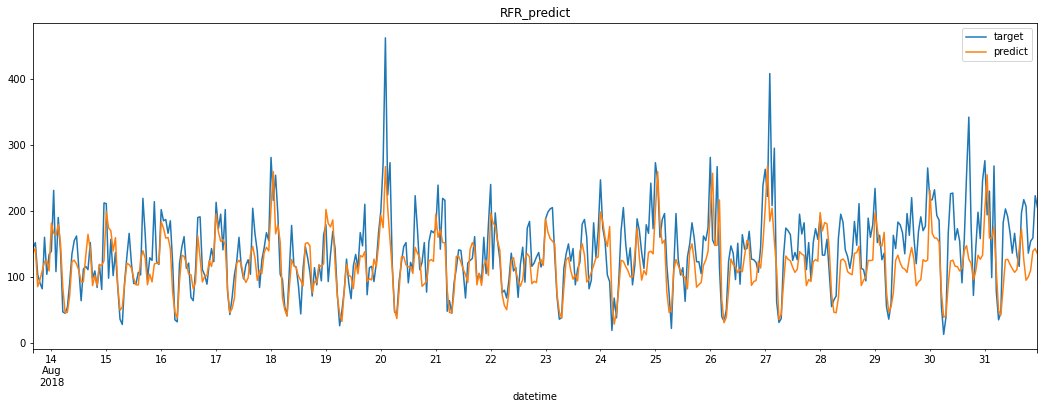

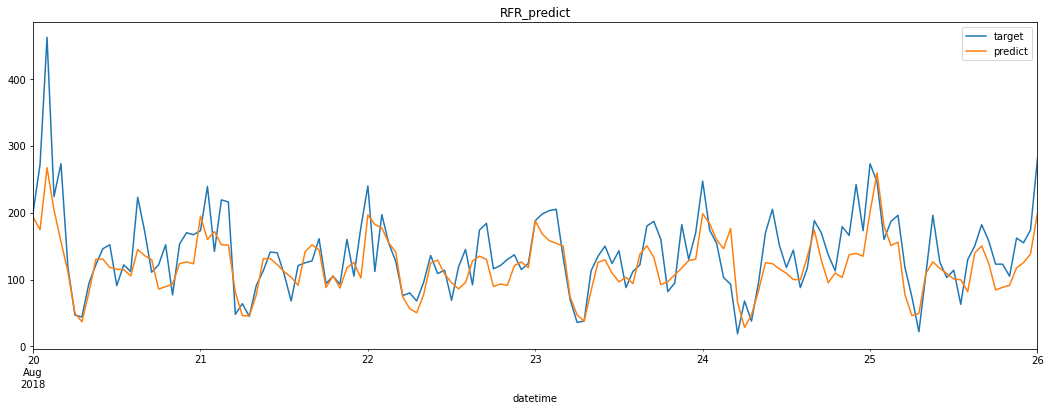

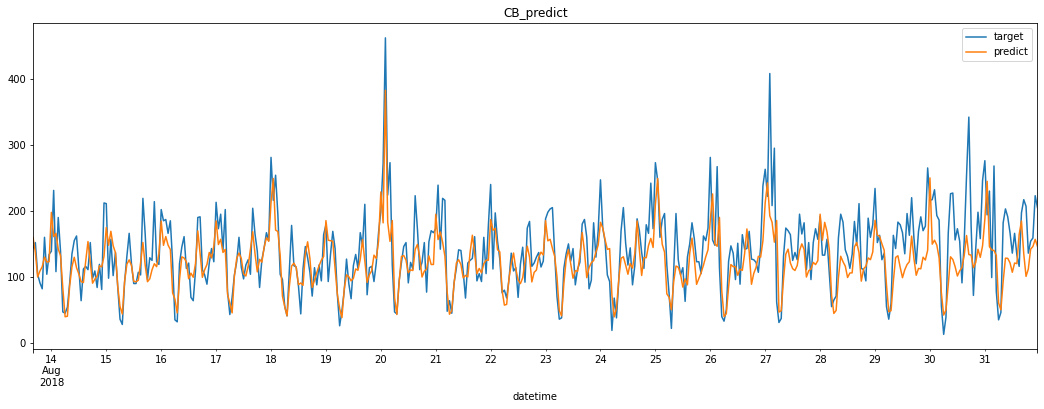

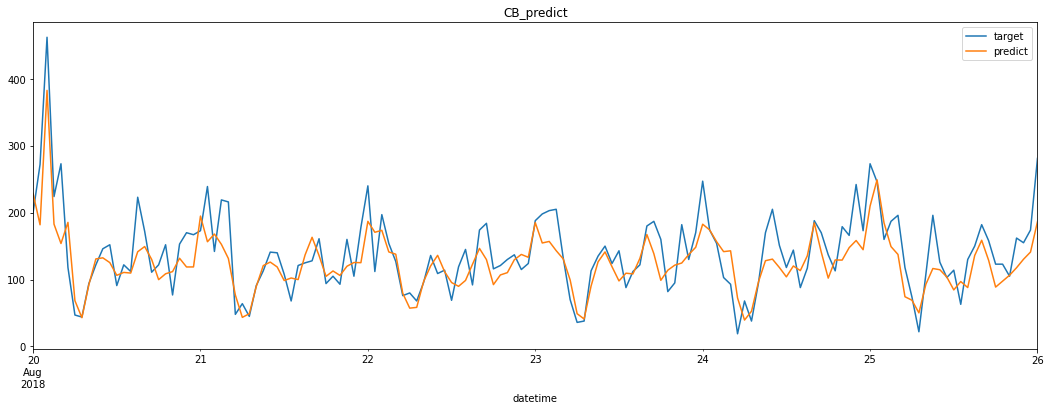

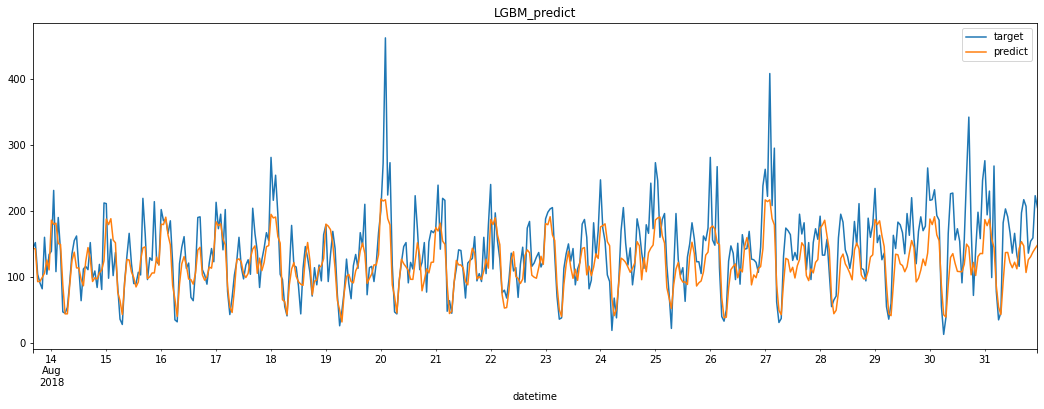

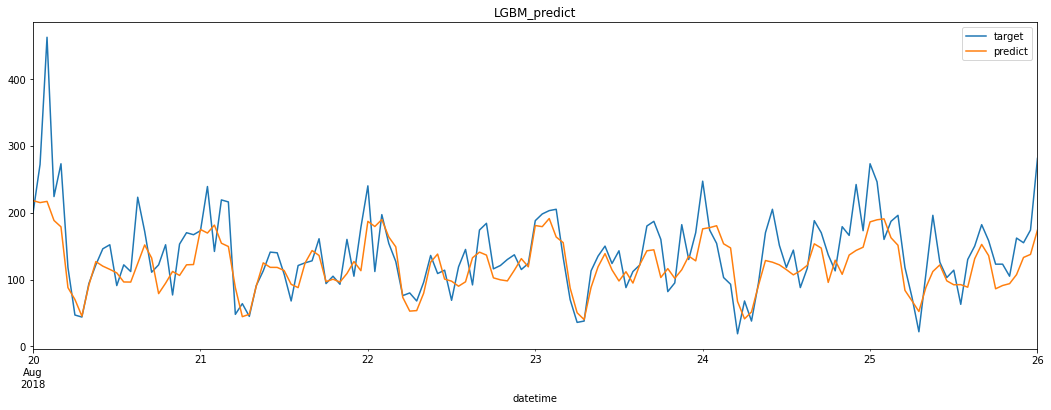

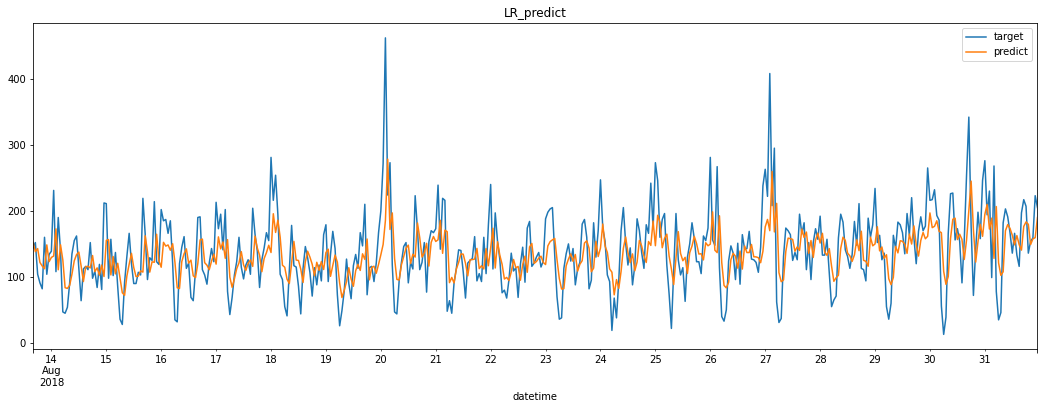

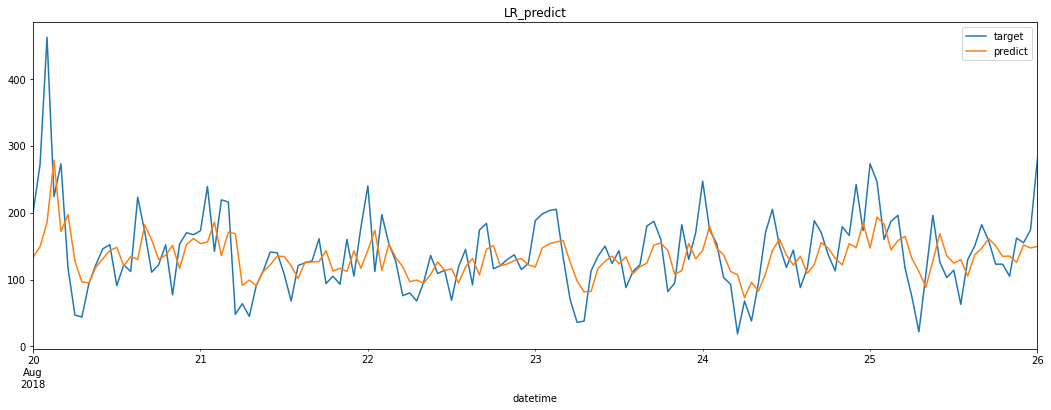

In [97]:
predict = [RFR_predict, CB_predict, LGBM_predict, LR_predict]
name = ['RFR_predict', 'CB_predict', 'LGBM_predict', 'LR_predict']
for predictions in range(len(predict)):
    model = pd.DataFrame({"target":target_test, "predict":predict[predictions]})
    model.plot(figsize=(18, 6))
    plt.title(label = name[predictions])
    model[152:297].plot(figsize=(18, 6))
    plt.title(label = name[predictions])